In [30]:
import os
import glob
import math
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import optimize, linalg, signal, stats

from sklearn.model_selection import KFold, GroupKFold, GridSearchCV, RepeatedKFold, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import RFE, RFECV, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

import keras
import tensorflow as tf
from keras import Model, layers, optimizers, losses, callbacks, regularizers, metrics, initializers

In [5]:
### Import Data
LN1_core = pd.read_excel(open('LN1.xlsx', 'rb'),sheet_name='core')  
LN2_core = pd.read_excel(open('LN2.xlsx', 'rb'),sheet_name='core')  
LN3_core = pd.read_excel(open('LN3.xlsx', 'rb'),sheet_name='core') 

LN1_log = pd.read_excel(open('LN1.xlsx', 'rb'),sheet_name='log')  
LN2_log = pd.read_excel(open('LN2.xlsx', 'rb'),sheet_name='log')  
LN3_log = pd.read_excel(open('LN3.xlsx', 'rb'),sheet_name='log')  

LN1_core ['WELL'] = 'LN1_core '
LN2_core ['WELL'] = 'LN2_core '
LN3_core ['WELL'] = 'LN3_core '

df_core = pd.concat([LN1_core ,LN2_core ,LN3_core])

df_core ["ln(k/phi)"] = np.log(df_core ['Kair(md)']/ df_core ['Por(%)'])
print('df_core: {}'.format(df_core.shape))
df_core.head()

df_core: (344, 23)


Depth(m)  RHOB (g/cc)  DTC(rho/m)  GD(g/cc)  CRHOB (g/cc)  GR(API)  \
0  2993.007     2.792038    288.1894     2.649      2.212015     57.3   
1  2993.317     2.359790    296.7534     2.657      2.217895     82.5   
2  2993.617     2.194946    304.3408     2.644      2.288896     93.4   
3  2993.937     2.559232    301.3028     2.644      2.338216     77.5   
4  2994.207     2.348028    302.3077     2.653      2.206690     91.9   

   Kair(md)       lnk  NPHI(v/v)  PEF(b/e)  ...  RSHAL(ohmm)   SW(v/v)  \
0    1950.0  7.575585   0.213187  2.675221  ...    11.189480  1.000000   
1     947.0  6.853299   0.251199  2.522506  ...    10.071730  0.581911   
2     977.0  6.884487   0.237218  2.513706  ...    11.670710  0.335579   
3     149.0  5.003946   0.267802  2.574758  ...     9.749550  0.948978   
4    2240.0  7.714231   0.251800  2.514174  ...     9.494773  0.481906   

   SWNET(v/v)  SXO(v/v)  SXONET(v/v)  VSHAL(v/v)       WELL  Permcalc(md)  \
0    1.000000  1.000000     1.000000    0.951741  LN1_core            NaN   
1    0.581911  0.897251     0.897251    0.352514  LN1_core            NaN   
2    0.335579  0.803588     0.803588    0.146957  LN1_core            NaN   
3    0.948978  0.987285     0.987285    0.697391  LN1_core            NaN   
4    0.481906  0.863907     0.863907    0.355592  LN1_core            NaN   

   PEF (b/e) ln(k/phi)  
0        NaN  4.298440  
1        NaN  3.576154  
2        NaN  3.811793  
3        NaN  2.080785  
4        NaN  4.418394  

[5 rows x 23 columns]

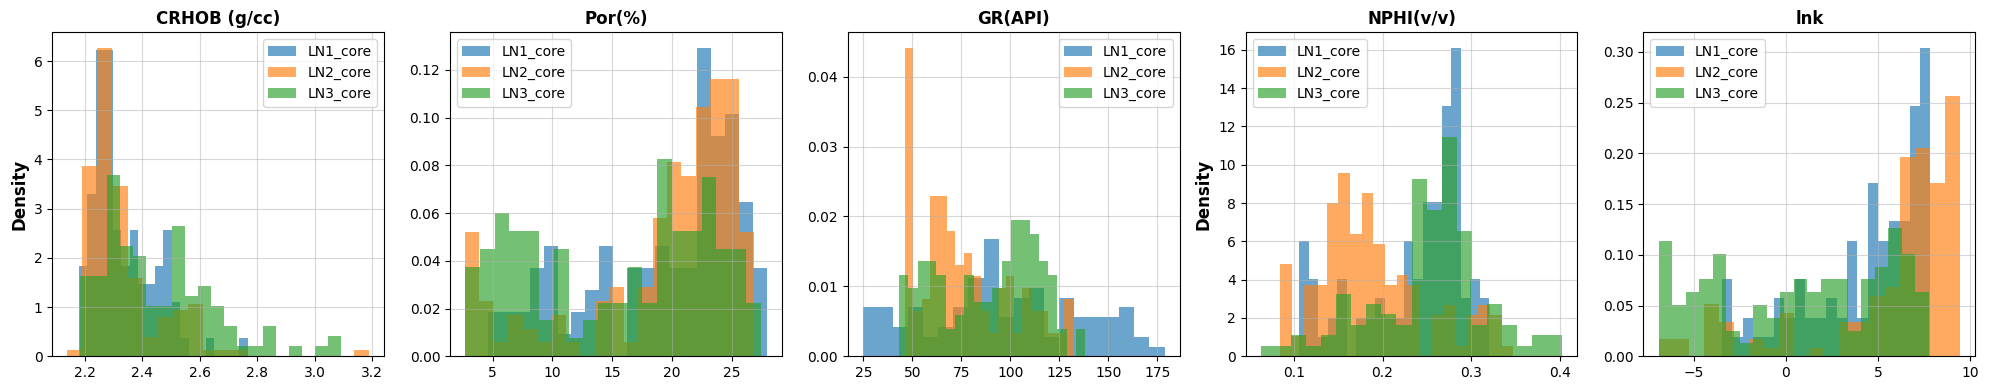

In [10]:
my_columns = ['CRHOB (g/cc)', 'Por(%)', 'GR(API)', 'NPHI(v/v)', 'lnk']

plt.figure(figsize=(20,4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.hist(LN1_core[my_columns].iloc[:,i], bins=20, density=True, alpha=0.66, label='LN1_core')
    plt.hist(LN2_core[my_columns].iloc[:,i], bins=20, density=True, alpha=0.66, label='LN2_core')
    plt.hist(LN3_core[my_columns].iloc[:,i], bins=20, density=True, alpha=0.66, label='LN3_core')
    plt.title(my_columns[i], fontweight='bold')
    plt.ylabel('Density', fontweight='bold',fontsize =12) if i % 3 == 0 else None  # Add ylabel only for the first column of each row
    plt.legend()
    plt.grid(True, which='both', alpha=0.5)

plt.tight_layout()
plt.show()


In [11]:
train = pd.concat([LN2_core,LN3_core])
X_train = train[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_train = train['lnk'] 
print('Train - x: {} | y: {}'.format(X_train.shape, y_train.shape))

X_test = LN1_core[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_test = LN1_core['lnk']
print('Test  - x: {} | y: {}'.format(X_test.shape, y_test.shape))

depth = LN1_core['Depth(m)']
print('Depth - {}'.format(depth.shape))

Train - x: (251, 4) | y: (251,)
Test  - x: (93, 4) | y: (93,)
Depth - (93,)


***
### Random Forest

In [18]:
# Define hyperparameter grid for Random Forest with overfitting prevention
n_estimators      = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
max_depth         = [int(x) for x in np.linspace(5, 50, num=10)]  # Limiting max depth to prevent overfitting
max_features      = ['sqrt']  # Using sqrt features instead of 'auto' to reduce complexity
min_samples_split = [10, 20, 50]  # Larger values to prevent splitting too much
min_samples_leaf  = [4, 8, 16]  # Larger values to create less complex trees

# Create the parameter grid
rf_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

# Initialize Random Forest model
rf_base = RandomForestRegressor(random_state=42)

# Set up the random search with cross-validation
rf_random = RandomizedSearchCV(
    estimator           = rf_base,
    param_distributions = rf_grid,
    scoring             = 'neg_mean_squared_error',  # Evaluation metric
    n_iter              = 30,                        # Number of parameter settings sampled
    cv                  = 5,                         # 5-fold cross-validation
    verbose             = 1,                         # Show progress
    random_state        = 42,                        # Random state for reproducibility
    n_jobs              = -1,                        # Use all processors
    )

# Fit the RandomizedSearchCV model on the training data
rf_random.fit(X_train, y_train)

# Output the best parameters found by the random search
print("Best parameters found: ", rf_random.best_params_)

# Use the best model from the random search to make predictions
y_train_pred = rf_random.best_estimator_.predict(X_train)
y_test_pred = rf_random.best_estimator_.predict(X_test)

# Evaluate the model to check for overfitting
print('MSE:  train: {:.3f}  | test: {:.3f}'.format(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R2:   train: {:.3f}  | test: {:.3f}'.format(r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Best parameters found:  {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 35}
MSE:  train: 1.715  | test: 2.767
R2:   train: 0.929  | test: 0.724


In [19]:
# Use the best model from the random search to make predictions
y_train_pred_rf = rf_random.best_estimator_.predict(X_train)
y_test_pred_rf = rf_random.best_estimator_.predict(X_test)

print('Pred: train: {} | test: {}'.format(y_train_pred_rf.shape, y_test_pred_rf.shape))

# Evaluate the model
print('MSE:  train: {:.3f}  | test: {:.3f}'.format(mean_squared_error(y_train, y_train_pred_rf), mean_squared_error(y_test, y_test_pred_rf)))
print('R2:   train: {:.3f}  | test: {:.3f}'.format(r2_score(y_train, y_train_pred_rf), r2_score(y_test, y_test_pred_rf)))

Pred: train: (251,) | test: (93,)
MSE:  train: 1.715  | test: 2.767
R2:   train: 0.929  | test: 0.724


In [21]:
# Train a RF model
rf_model = RandomForestRegressor(n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features= 'sqrt', max_depth = 35, random_state=42)
rf_model.fit(X_train, y_train)

# Use the best model from the random search to make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
print('Pred: train: {} | test: {}'.format(y_train_pred_rf.shape, y_test_pred_rf.shape))

# Evaluate the model
print('MSE:  train: {:.3f}  | test: {:.3f}'.format(mean_squared_error(y_train, y_train_pred_rf), mean_squared_error(y_test, y_test_pred_rf)))
print('R2:   train: {:.3f}  | test: {:.3f}'.format(r2_score(y_train, y_train_pred_rf), r2_score(y_test, y_test_pred_rf)))

Pred: train: (251,) | test: (93,)
MSE:  train: 1.715  | test: 2.767
R2:   train: 0.929  | test: 0.724


In [22]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred_rf, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred_rf, marker='o', alpha=0.66, color='C1', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('RF predictions')
plt.xlabel('True lnk'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

***
### Extreme Gradient Boosting

In [23]:
# Define the model
xgb_model = XGBRegressor(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators':     [50, 100, 200],
    'max_depth':        [3, 5, 7],
    'learning_rate':    [0.01, 0.05, 0.1],
    'subsample':        [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator  = xgb_model, 
                           param_grid = param_grid, 
                           scoring    = 'neg_mean_squared_error', 
                           cv         = 5, 
                           verbose    = 1,
                           n_jobs     = -1)

# Fit the model
grid_search.fit(X_train.values, y_train.values)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", best_params)

# Predict and evaluate using the best model
y_train_pred_xgb = best_model.predict(X_train.values)
y_test_pred_xgb = best_model.predict(X_test.values)

print('Pred: train: {} | test: {}'.format(y_train_pred_xgb.shape, y_test_pred_xgb.shape))
print('MSE:  train: {:.3f}  | test: {:.3f}'.format(mean_squared_error(y_train, y_train_pred_xgb), mean_squared_error(y_test, y_test_pred_xgb)))
print('R2:   train: {:.3f}  | test: {:.3f}'.format(r2_score(y_train, y_train_pred_xgb), r2_score(y_test, y_test_pred_xgb)))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Pred: train: (251,) | test: (93,)
MSE:  train: 1.281  | test: 3.401
R2:   train: 0.947  | test: 0.660


In [24]:
# Define the model
xgb_model = XGBRegressor(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators':     [50, 100, 200, 500, 1000],  # Expanded number of estimators
    'max_depth':        [3, 5, 7, 10],              # Also added a deeper tree for exploration
    'learning_rate':    [0.01, 0.05, 0.1, 0.2],     # Expanded learning rates for more flexibility
    'subsample':        [0.6, 0.8, 1],              # Added a lower subsample value
    'colsample_bytree': [0.6, 0.8, 1],              # Expanded column sampling
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator  = xgb_model, 
                           param_grid = param_grid, 
                           scoring    = 'neg_mean_squared_error', 
                           cv         = 5, 
                           verbose    = 1,
                           n_jobs     = -1)

# Fit the model
grid_search.fit(X_train.values, y_train.values)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", best_params)

# Predict and evaluate using the best model
y_train_pred_xgb = best_model.predict(X_train.values)
y_test_pred_xgb = best_model.predict(X_test.values)

print('Pred: train: {} | test: {}'.format(y_train_pred_xgb.shape, y_test_pred_xgb.shape))
print('MSE:  train: {:.3f}  | test: {:.3f}'.format(mean_squared_error(y_train, y_train_pred_xgb), mean_squared_error(y_test, y_test_pred_xgb)))
print('R2:   train: {:.3f}  | test: {:.3f}'.format(r2_score(y_train, y_train_pred_xgb), r2_score(y_test, y_test_pred_xgb)))

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters found:  {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Pred: train: (251,) | test: (93,)
MSE:  train: 1.327  | test: 3.369
R2:   train: 0.945  | test: 0.664


In [25]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred_xgb, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred_xgb, marker='o', alpha=0.66, color='C1', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('XGB predictions')
plt.xlabel('True lnk'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

In [26]:
# Train an XGBoost model
xgb_model = XGBRegressor(colsample_bytree = 0.8, learning_rate = 0.1, max_depth = 3, n_estimators = 50, subsample = 0.8, random_state=42)
xgb_model.fit(X_train.values, y_train.values)

y_train_pred = xgb_model.predict(X_train.values)
y_test_pred  = xgb_model.predict(X_test.values)
print('Pred: train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))
print('MSE:  train: {:.3f}  | test: {:.3f}'.format(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R2:   train: {:.3f}  | test: {:.3f}'.format(r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Pred: train: (251,) | test: (93,)
MSE:  train: 1.281  | test: 3.401
R2:   train: 0.947  | test: 0.660


In [27]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred, marker='o', alpha=0.66, color='C1', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('XGB predictions')
plt.xlabel('True lnk'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

***
### ANN

In [28]:
data_train = pd.concat([LN2_core, LN3_core])[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]
data_test  = LN1_core[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]

mu,   sd   = data_train.mean(), data_train.std()
dmin, dmax = data_train.min(), data_train.max()

data_train_norm = (data_train - mu) / sd
data_test_norm  = (data_test - mu) / sd

#data_train_norm = (data_train - dmin) / (dmax - dmin)
# data_test_norm  = (data_test - dmin) / (dmax - dmin)

X_train_norm = data_train_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_train_norm = data_train_norm['lnk']
print('X_train_norm: {} | y_train_norm: {}'.format(X_train_norm.shape, y_train_norm.shape))

X_test_norm = data_test_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_test_norm = data_test_norm['lnk']
print('X_test_norm:  {} | y_test_norm:  {}'.format(X_test_norm.shape, y_test_norm.shape))

X_train_norm: (251, 4) | y_train_norm: (251,)
X_test_norm:  (93, 4) | y_test_norm:  (93,)


In [29]:
def make_model(n_layers:int=4, units:int=128, alpha:float=0.01, nonlinearity:str='relu'):

    def linear_bn_relu(x, units, nl=nonlinearity, a=alpha):
        x = layers.Dense(units, kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(a))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(nl)(x)
        return x

    inp = layers.Input(shape=(X_train.shape[1],))
    x = inp
    for _ in range(n_layers):
        x = linear_bn_relu(x, units)
    out = layers.Dense(1)(x)

    return Model(inputs=inp, outputs=out)

In [33]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model_ann = make_model(n_layers=4, units=128, nonlinearity='relu')
print('# parameters: {:,}'.format(model_ann.count_params()))

model_ann.compile(optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-2), 
                  loss      = losses.MeanSquaredError(), 
                  metrics   = [metrics.MeanSquaredError()])

start = time()
fit = model_ann.fit(X_train_norm, y_train_norm, 
                    epochs           = 250, 
                    batch_size       = 10,
                    validation_split = 0.25,
                    shuffle          = True,
                    verbose          = 0,
                    callbacks=[early_stopping])
print('Training time: {:.3f} seconds'.format(time()-start))
fit = pd.DataFrame(fit.history)

# parameters: 52,353
Training time: 17.088 seconds


In [34]:
# Predict and back-transform
y_train_pred_nn = model_ann.predict(X_train_norm, verbose=False) * sd['lnk'] + mu['lnk']
y_test_pred_nn  = model_ann.predict(X_test_norm, verbose=False) * sd['lnk'] + mu['lnk']
print('NN - train: {} | test: {}'.format(y_train_pred_nn.shape, y_test_pred_nn.shape))

print('MSE: train: {:.3f} | test: {:.3f}'.format(mean_squared_error(data_train['lnk'], y_train_pred_nn), mean_squared_error(data_test['lnk'], y_test_pred_nn)))
print('R2:  train: {:.3f} | test: {:.3f}'.format(r2_score(data_train['lnk'], y_train_pred_nn), r2_score(data_test['lnk'], y_test_pred_nn)))

NN - train: (251, 1) | test: (93, 1)
MSE: train: 4.247 | test: 5.812
R2:  train: 0.825 | test: 0.420


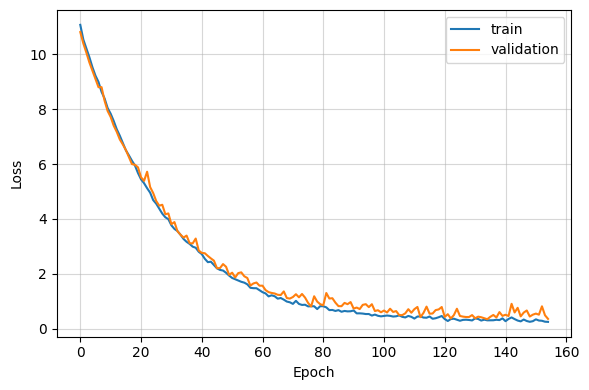

In [35]:
plt.figure(figsize=(6,4))
plt.plot(fit['loss'], label='train')
plt.plot(fit['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.tight_layout()
plt.show()

In [36]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred_nn, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred_nn, marker='o', alpha=0.66, color='tab:brown', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('ANN predictions')
plt.xlabel('True lnK'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

***
### LSTM

In [37]:
# Reshape the data to 3D for LSTM (samples, timesteps, features)
# Assuming that each sample is a single timestep, you can reshape as:
X_train_norm_lstm = np.expand_dims(X_train_norm.values, axis=1)  # Shape: (samples, timesteps=1, features)
X_test_norm_lstm = np.expand_dims(X_test_norm.values, axis=1)

print('X_train_norm_lstm shape:', X_train_norm_lstm.shape)
print('X_test_norm_lstm shape:', X_test_norm_lstm.shape)

X_train_norm_lstm shape: (251, 1, 4)
X_test_norm_lstm shape: (93, 1, 4)


In [38]:
def make_lstm_model(n_layers:int=2, units:int=128, alpha:float=0.01):

    inp = layers.Input(shape=(X_train_norm_lstm.shape[1], X_train_norm_lstm.shape[2]))
    x = inp
    for i in range(n_layers):
        # Return_sequences=True for stacked LSTM layers, False for the final one
        return_sequences = True if i < n_layers - 1 else False
        x = layers.LSTM(units, return_sequences=return_sequences,
                 kernel_initializer=initializers.HeNormal(),
                 kernel_regularizer=regularizers.l2(alpha))(x)
        x = layers.BatchNormalization()(x)
    
    # Output layer
    out = layers.Dense(1)(x)

    return Model(inputs=inp, outputs=out)

In [39]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

model_lstm = make_lstm_model(n_layers=4, units=128, alpha=0.01)
print('# parameters: {:,}'.format(model_lstm.count_params()))

model_lstm.compile(optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-2), 
                   loss      = losses.MeanSquaredError(), 
                   metrics   = [metrics.MeanSquaredError()])

start = time()
fit = model_lstm.fit(X_train_norm_lstm, y_train_norm, 
                epochs           = 200, 
                batch_size       = 10,
                validation_split = 0.25,
                shuffle          = True,
                verbose          = 0,
                callbacks        = [early_stopping])

print('Training time: {:.3f} seconds'.format(time()-start))
fit = pd.DataFrame(fit.history)

# parameters: 465,025
Training time: 165.057 seconds


In [40]:
# Predict and back-transform
y_train_pred_lstm = model_lstm.predict(X_train_norm_lstm, verbose=False) * sd['lnk'] + mu['lnk']
y_test_pred_lstm  = model_lstm.predict(X_test_norm_lstm, verbose=False) * sd['lnk'] + mu['lnk']
print('LSTM - train: {} | test: {}'.format(y_train_pred_lstm.shape, y_test_pred_lstm.shape))

print('MSE: train: {:.3f} | test: {:.3f}'.format(mean_squared_error(data_train['lnk'], y_train_pred_lstm), mean_squared_error(data_test['lnk'], y_test_pred_lstm)))
print('R2:  train: {:.3f} | test: {:.3f}'.format(r2_score(data_train['lnk'], y_train_pred_lstm), r2_score(data_test['lnk'], y_test_pred_lstm)))

LSTM - train: (251, 1) | test: (93, 1)
MSE: train: 3.772 | test: 3.622
R2:  train: 0.845 | test: 0.638


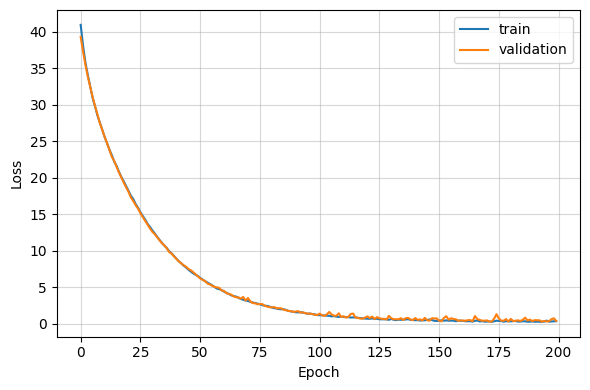

In [41]:
plt.figure(figsize=(6,4))
plt.plot(fit['loss'], label='train')
plt.plot(fit['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.tight_layout()
plt.show()

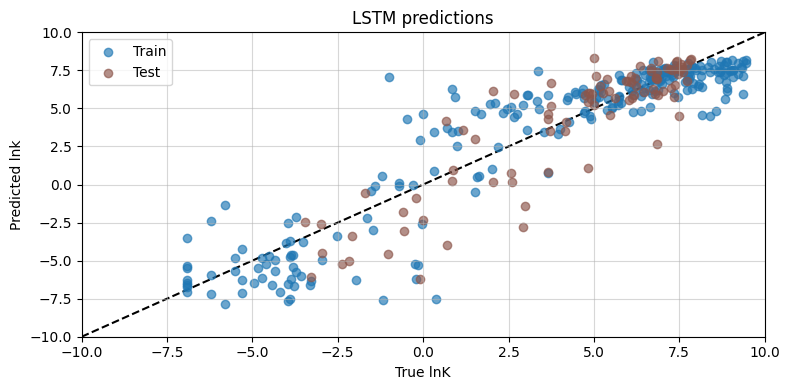

In [42]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred_lstm, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred_lstm, marker='o', alpha=0.66, color='tab:brown', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('LSTM predictions')
plt.xlabel('True lnK'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

***
### 1D CNN

In [45]:
data_train = pd.concat([LN2_core, LN3_core])[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]
data_test  = LN1_core[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]

mu,   sd   = data_train.mean(), data_train.std()
dmin, dmax = data_train.min(), data_train.max()

data_train_norm = (data_train - mu) / sd
data_test_norm  = (data_test - mu) / sd

#data_train_norm = (data_train - dmin) / (dmax - dmin)
# data_test_norm  = (data_test - dmin) / (dmax - dmin)

X_train_norm = data_train_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_train_norm = data_train_norm['lnk']
print('X_train_norm: {} | y_train_norm: {}'.format(X_train_norm.shape, y_train_norm.shape))

X_test_norm = data_test_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_test_norm = data_test_norm['lnk']
print('X_test_norm:  {} | y_test_norm:  {}'.format(X_test_norm.shape, y_test_norm.shape))

X_train_norm: (251, 4) | y_train_norm: (251,)
X_test_norm:  (93, 4) | y_test_norm:  (93,)


In [46]:
# Reshape the data to 3D for 1D CNN (samples, timesteps, features)
X_train_norm_cnn = np.expand_dims(X_train_norm.values, axis=-1)  # Shape: (samples, features, channels)
X_test_norm_cnn = np.expand_dims(X_test_norm.values, axis=-1)

print('X_train_norm_cnn shape:', X_train_norm_cnn.shape)
print('X_test_norm_cnn shape:', X_test_norm_cnn.shape)

X_train_norm_cnn shape: (251, 4, 1)
X_test_norm_cnn shape: (93, 4, 1)


In [47]:
def make_cnn_model(n_layers:int=3, filters:int=64, kernel_size:int=3, alpha:float=0.01):
    inp = layers.Input(shape=(X_train_norm_cnn.shape[1], X_train_norm_cnn.shape[2]))  # (features, channels)
    x = inp

    for _ in range(n_layers):
        x = layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',
                   padding='same',
                   kernel_initializer=initializers.HeNormal(),
                   kernel_regularizer=regularizers.l2(alpha),
                   )(x)
        x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)

    out = layers.Dense(1)(x)

    return Model(inputs=inp, outputs=out)

In [48]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

model_cnn = make_cnn_model(n_layers=6, filters=128, kernel_size=3, alpha=0.01)
print('# parameters: {:,}'.format(model_cnn.count_params()))

model_cnn.compile(optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-2), 
                  loss      = losses.MeanSquaredError(), 
                  metrics   = [metrics.MeanSquaredError()])

start = time()
fit = model_cnn.fit(X_train_norm_cnn, y_train_norm, 
                epochs           = 200, 
                batch_size       = 10,
                validation_split = 0.25,
                shuffle          = True,
                verbose          = 0,
                callbacks        = [early_stopping])

print('Training time: {:.3f} seconds'.format(time()-start))
fit = pd.DataFrame(fit.history)

# parameters: 250,497
Training time: 30.260 seconds


In [49]:
# Predict and back-transform
y_train_pred_cnn = model_cnn.predict(X_train_norm_cnn, verbose=False) * sd['lnk'] + mu['lnk']
y_test_pred_cnn  = model_cnn.predict(X_test_norm_cnn, verbose=False) * sd['lnk'] + mu['lnk']
print('CNN - train: {} | test: {}'.format(y_train_pred_cnn.shape, y_test_pred_cnn.shape))

print('MSE: train: {:.3f} | test: {:.3f}'.format(mean_squared_error(data_train['lnk'], y_train_pred_cnn), mean_squared_error(data_test['lnk'], y_test_pred_cnn)))
print('R2:  train: {:.3f} | test: {:.3f}'.format(r2_score(data_train['lnk'], y_train_pred_cnn), r2_score(data_test['lnk'], y_test_pred_cnn)))

CNN - train: (251, 1) | test: (93, 1)
MSE: train: 3.298 | test: 3.989
R2:  train: 0.864 | test: 0.602


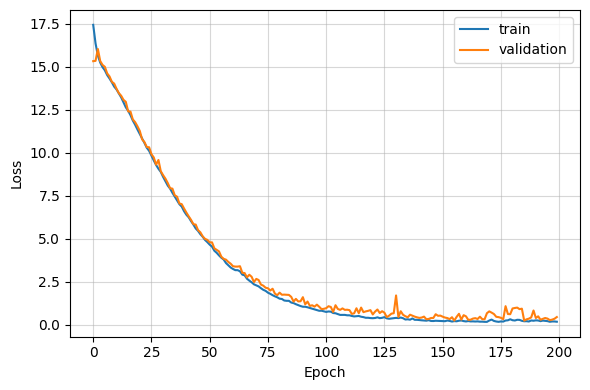

In [50]:
plt.figure(figsize=(6,4))
plt.plot(fit['loss'], label='train')
plt.plot(fit['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.tight_layout()
plt.show()

In [51]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred_cnn, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred_cnn, marker='o', alpha=0.66, color='tab:red', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('CNN predictions')
plt.xlabel('True lnK'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

***
### cGAN 2

In [52]:
# Assuming LN1_core, LN2_core, and LN3_core are already defined pandas DataFrames
data_train = pd.concat([LN2_core, LN3_core])[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]
data_test  = LN1_core[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]

# Normalize the data using Z-score normalization
mu, sd = data_train.mean(), data_train.std()

data_train_norm = (data_train - mu) / sd
data_test_norm  = (data_test - mu) / sd

X_train_norm = data_train_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']].values
y_train_norm = data_train_norm['lnk'].values
print('X_train_norm: {} | y_train_norm: {}'.format(X_train_norm.shape, y_train_norm.shape))

X_test_norm = data_test_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']].values
y_test_norm = data_test_norm['lnk'].values
print('X_test_norm:  {} | y_test_norm:  {}'.format(X_test_norm.shape, y_test_norm.shape))

# Convert to TensorFlow datasets
buffer_size = len(X_train_norm)
batch_size = 64  # Adjust based on your data size and GPU memory
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train_norm))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test_norm))
test_dataset = test_dataset.batch(batch_size)

X_train_norm: (251, 4) | y_train_norm: (251,)
X_test_norm:  (93, 4) | y_test_norm:  (93,)


In [53]:
def build_generator(input_dim=4, n_layers=4, units=128, alpha=0.01, nonlinearity='relu'):
    inp = layers.Input(shape=(input_dim,))
    x = inp
    for _ in range(n_layers):
        x = layers.Dense(units, kernel_initializer=initializers.HeNormal(), 
                         kernel_regularizer=regularizers.l2(alpha))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(nonlinearity)(x)
    out = layers.Dense(1)(x)
    return Model(inputs=inp, outputs=out, name='generator')

generator = build_generator(input_dim=4, n_layers=5, units=128, alpha=1e-2, nonlinearity='relu')
print('# parameters - generator: {:,}'.format(generator.count_params()))

# parameters - generator: 69,377


In [54]:
def build_discriminator(input_dim=4, n_layers=4, units=128, alpha=0.01, nonlinearity='relu'):
    inp_features = layers.Input(shape=(input_dim,))
    inp_lnk = layers.Input(shape=(1,))
    x = layers.Concatenate()([inp_features, inp_lnk])
    for _ in range(n_layers):
        x = layers.Dense(units, kernel_initializer=initializers.HeNormal(), 
                         kernel_regularizer=regularizers.l2(alpha))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(nonlinearity)(x)
    out = layers.Dense(1, activation='sigmoid')(x)  # Real or Fake
    return Model(inputs=[inp_features, inp_lnk], outputs=out, name='discriminator')

discriminator = build_discriminator(input_dim=4, n_layers=5, units=128, alpha=1e-2, nonlinearity='relu')
print('# parameters - discriminator: {:,}'.format(discriminator.count_params()))

# parameters - discriminator: 69,505


In [55]:
discriminator.compile(optimizer = optimizers.Adam(learning_rate=1e-4, beta_1=0.5), 
                      loss      = 'binary_crossentropy',
                      metrics   = ['accuracy'])

In [56]:
# Freeze the discriminator's weights when training the generator via the combined model
discriminator.trainable = False

# Input to the generator
gen_input = layers.Input(shape=(4,))
# Generator output
gen_output = generator(gen_input)
# Discriminator output
disc_output = discriminator([gen_input, gen_output])

# Combined model
combined = Model(inputs=gen_input, outputs=disc_output, name='combined')
combined.compile(optimizer = optimizers.Adam(learning_rate=1e-4, beta_1=0.5), 
                 loss      = 'binary_crossentropy')

In [57]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)  # because of sigmoid activation

def discriminator_loss(real_output, fake_output):
    real_loss  = cross_entropy(tf.ones_like(real_output), real_output)  # Label=1 for real
    fake_loss  = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Label=0 for fake
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output, real_lnk, generated_lnk, mse_weight=100):
    # Adversarial loss: want discriminator to classify fake as real
    adv_loss = cross_entropy(tf.ones_like(fake_output), fake_output)  # Label=1 for generator to fool
    # Regression loss: MSE between generated 'lnk' and real 'lnk'
    mse = tf.keras.losses.MeanSquaredError()(real_lnk, generated_lnk)
    # Combine losses
    total_loss = adv_loss + mse_weight * mse
    return total_loss

# Define optimizers
generator_optimizer = optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

In [60]:
# Define training parameters
epochs = 250
batch_size = 64

# Define metrics for tracking
train_loss = metrics.Mean(name='train_loss')
train_d_loss = metrics.Mean(name='train_d_loss')
train_g_loss = metrics.Mean(name='train_g_loss')

# Define the training step using @tf.function for performance
@tf.function
def train_step(features, real_lnk):
    real_lnk = tf.expand_dims(real_lnk, axis=1)  # Shape: (batch_size, 1)
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake 'lnk'
        fake_lnk = generator(features, training=True)  # Shape: (batch_size, 1)
        
        # Discriminator output for real and fake data
        real_output = discriminator([features, real_lnk], training=True)
        fake_output = discriminator([features, fake_lnk], training=True)
        
        # Compute losses
        d_loss = discriminator_loss(real_output, fake_output)
        g_loss = generator_loss(fake_output, real_lnk, fake_lnk)
    
    # Calculate the gradients for discriminator and generator
    d_gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    g_gradients = tape.gradient(g_loss, generator.trainable_variables)
    
    # Apply the gradients to the optimizers
    discriminator_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    
    # Update the metrics
    train_d_loss(d_loss)
    train_g_loss(g_loss)
    train_loss(d_loss + g_loss)
    
    return d_loss, g_loss

In [61]:
start_time = time()

for epoch in range(1, epochs + 1):
    train_loss.reset_states()
    train_d_loss.reset_states()
    train_g_loss.reset_states()
    
    for batch_features, batch_lnk in train_dataset:
        d_loss, g_loss = train_step(batch_features, batch_lnk)
    
    # Logging the progress
    if epoch % 50 == 0 or epoch == 1:
        print(f'Epoch {epoch}, Loss: {train_loss.result():.4f}, D Loss: {train_d_loss.result():.4f}, G Loss: {train_g_loss.result():.4f}')
    
    # Optional: Implement early stopping based on custom criteria
    # For simplicity, it's not included here

print('Training time: {:.3f} seconds'.format(time() - start_time))

AttributeError: 'Mean' object has no attribute 'reset_states'

In [236]:
y_train_pred_norm = generator.predict(X_train_norm, batch_size=batch_size).flatten()
y_test_pred_norm  = generator.predict(X_test_norm, batch_size=batch_size).flatten()

y_train_pred_gan2 = y_train_pred_norm * sd['lnk'] + mu['lnk']
y_test_pred_gan2  = y_test_pred_norm * sd['lnk'] + mu['lnk']
print('GAN - train: {} | test: {}'.format(y_train_pred_gan2.shape, y_test_pred_gan2.shape))

print('MSE: train: {:.3f} | test: {:.3f}'.format(mean_squared_error(data_train['lnk'], y_train_pred_gan2), mean_squared_error(data_test['lnk'], y_test_pred_gan2)))
print('R2:  train: {:.3f} | test: {:.3f}'.format(r2_score(data_train['lnk'], y_train_pred_gan2), r2_score(data_test['lnk'], y_test_pred_gan2)))

2/2 [==============================] - 0s 0s/step
GAN - train: (251,) | test: (93,)
MSE: train: 0.563 | test: 6.338
R2:  train: 0.977 | test: 0.367


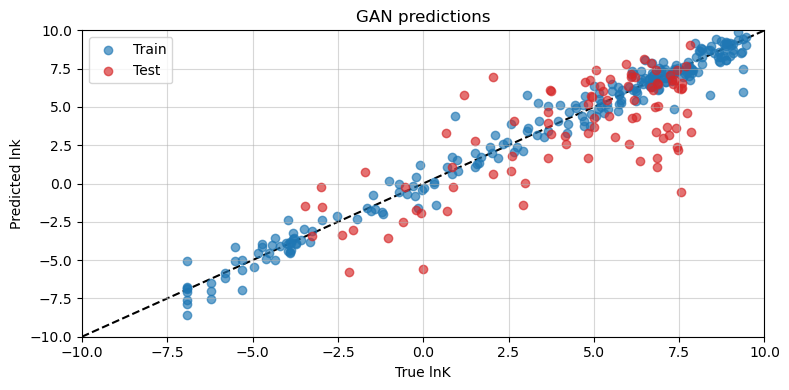

In [237]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred_gan2, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred_gan2, marker='o', alpha=0.66, color='tab:red', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('GAN predictions')
plt.xlabel('True lnK'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

In [ ]:
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')

***
### cVAE

In [ ]:
### Import Data
LN1_core = pd.read_excel(open('LN1.xlsx', 'rb'),sheet_name='core')  
LN2_core = pd.read_excel(open('LN2.xlsx', 'rb'),sheet_name='core')  
LN3_core = pd.read_excel(open('LN3.xlsx', 'rb'),sheet_name='core') 

LN1_log = pd.read_excel(open('LN1.xlsx', 'rb'),sheet_name='log')  
LN2_log = pd.read_excel(open('LN2.xlsx', 'rb'),sheet_name='log')  
LN3_log = pd.read_excel(open('LN3.xlsx', 'rb'),sheet_name='log')  

LN1_core ['WELL'] = 'LN1_core '
LN2_core ['WELL'] = 'LN2_core '
LN3_core ['WELL'] = 'LN3_core '

In [329]:
# Assuming LN1_core, LN2_core, and LN3_core are already defined pandas DataFrames
data_train = pd.concat([LN2_core, LN3_core])[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]
data_test  = LN1_core[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]

# Normalize the data using Z-score normalization
mu, sd = data_train.mean(), data_train.std()

data_train_norm = (data_train - mu) / sd
data_test_norm  = (data_test - mu) / sd

X_train_norm = data_train_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_train_norm = data_train_norm['lnk']
print('X_train_norm: {} | y_train_norm: {}'.format(X_train_norm.shape, y_train_norm.shape))

X_test_norm = data_test_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_test_norm = data_test_norm['lnk']
print('X_test_norm:  {} | y_test_norm:  {}'.format(X_test_norm.shape, y_test_norm.shape))

X_train_norm: (251, 4) | y_train_norm: (251,)
X_test_norm:  (93, 4) | y_test_norm:  (93,)


In [335]:
# Define the Encoder
def cvae_encoder(input_dim, cond_dim, latent_dim=4):
    # Inputs
    input_data = layers.Input(shape=(input_dim,), name='input_data')
    cond_data = layers.Input(shape=(cond_dim,), name='cond_data')

    # Concatenate inputs
    merged_inputs = layers.Concatenate(name='merged_inputs')([input_data, cond_data])
    x = layers.Dense(128, activation='relu')(merged_inputs)
    x = layers.Dense(64, activation='relu')(x)

    # Latent space
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
    
    # Create model
    return Model(inputs=[input_data, cond_data], outputs=[z_mean, z_log_var, z], name='encoder')

# Define the Decoder
def cvae_decoder(latent_dim, cond_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='latent_inputs')
    cond_inputs = layers.Input(shape=(cond_dim,), name='cond_inputs')

    merged_inputs = layers.Concatenate()([latent_inputs, cond_inputs])
    x = layers.Dense(64, activation='relu')(merged_inputs)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(1, name='output')(x)

    return Model(inputs=[latent_inputs, cond_inputs], outputs=out, name='decoder')

# CVAE Model
class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        input_data, cond_data = inputs
        z_mean, z_log_var, z = self.encoder([input_data, cond_data])
        reconstructed = self.decoder([z, cond_data])
        return reconstructed

    def train_step(self, data):
        x, y = data  # Unpack the data. These are the inputs (features and target).

        with tf.GradientTape() as tape:
            reconstructed = self(x, training=True)  # Compute input reconstruction.
            loss = self.compiled_loss(y, reconstructed)  # Compute the loss value.

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, reconstructed)

        # Return a dict mapping metric names to current value.
        return {m.name: m.result() for m in self.metrics}

# Instantiate and compile the CVAE
latent_dim = 4
input_dim = 4  # Number of input features
cond_dim = 1   # Number of conditional variables (lnk)

encoder = cvae_encoder(input_dim=input_dim, cond_dim=cond_dim, latent_dim=latent_dim)
decoder = cvae_decoder(latent_dim=latent_dim, cond_dim=cond_dim)

cvae = CVAE(encoder, decoder)
cvae.compile(optimizer='adam', loss='mse')

# Fit the model with a portion of the training data used for validation
history = cvae.fit(x=[X_train_norm, y_train_norm], y=y_train_norm,
                   epochs           = 100,
                   batch_size       = 32,
                   validation_split =0.25,
                   shuffle          = True,
                   verbose          = 0)

Epoch 1/100
6/6 [==============================] - 0s 31ms/step - loss: 0.8086 - val_loss: 0.7926
Epoch 2/100
6/6 [==============================] - 0s 27ms/step - loss: 0.4100 - val_loss: 0.3820
Epoch 3/100
6/6 [==============================] - 0s 27ms/step - loss: 0.1641 - val_loss: 0.1375
Epoch 4/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0815 - val_loss: 0.0918
Epoch 5/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0488 - val_loss: 0.0732
Epoch 6/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0299 - val_loss: 0.0332
Epoch 7/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0220 - val_loss: 0.0147
Epoch 8/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0174 - val_loss: 0.0065
Epoch 9/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0092 - val_loss: 0.0192
Epoch 10/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0068 - val_loss: 0.0107
Epoch 11/100
6/6 [=

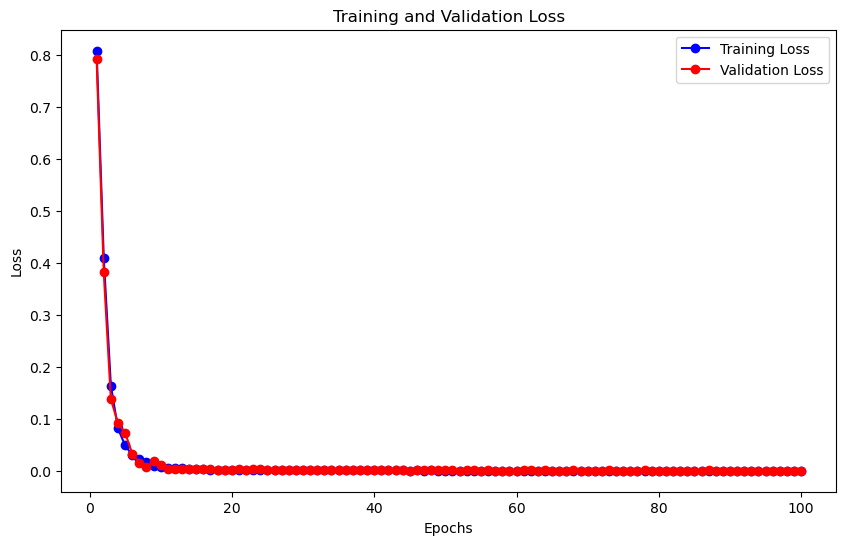

In [336]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting both the training loss and the validation loss
plt.figure(figsize=(10, 6))  # Optional: you can define the figure size
plt.plot(epochs, loss, 'bo-', label='Training Loss')  # 'bo' gives blue color and dot markers
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')  # 'ro' gives red color and dot markers
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [337]:
# Generate predictions
# The model should receive inputs as a list of [X_train_norm, y_train_norm]
y_train_pred_norm = cvae.predict([X_train_norm, y_train_norm], batch_size=32).flatten()
y_test_pred_norm = cvae.predict([X_test_norm, y_test_norm], batch_size=32).flatten()

# Back-transform the predictions
# Assume 'mu' and 'sd' are the mean and std. dev. used to normalize 'lnk'
y_train_pred_cvae = y_train_pred_norm * sd['lnk'] + mu['lnk']
y_test_pred_cvae = y_test_pred_norm * sd['lnk'] + mu['lnk']

print('CVAE - train: {} | test: {}'.format(y_train_pred_cvae.shape, y_test_pred_cvae.shape))

# Evaluate the predictions
train_mse = mean_squared_error(data_train['lnk'], y_train_pred_cvae)
test_mse = mean_squared_error(data_test['lnk'], y_test_pred_cvae)
train_r2 = r2_score(data_train['lnk'], y_train_pred_cvae)
test_r2 = r2_score(data_test['lnk'], y_test_pred_cvae)

print(f'MSE: train: {train_mse:.3f} | test: {test_mse:.3f}')
print(f'R2:  train: {train_r2:.3f} | test: {test_r2:.3f}')

3/3 [==============================] - 0s 2ms/step
CVAE - train: (251,) | test: (93,)
MSE: train: 0.006 | test: 0.006
R2:  train: 1.000 | test: 0.999


In [338]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred_cvae, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred_cvae, marker='o', alpha=0.66, color='tab:red', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('VAE predictions')
plt.xlabel('True lnK'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

***
### Ensemble

In [ ]:
train = pd.concat([LN2_core,LN3_core])
X_train = train[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_train = train['lnk'] 
print('Train - x: {} | y: {}'.format(X_train.shape, y_train.shape))

X_test = LN1_core[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_test = LN1_core['lnk']
print('Test  - x: {} | y: {}'.format(X_test.shape, y_test.shape))

depth = LN1_core['Depth(m)']
print('Depth - {}'.format(depth.shape))

In [ ]:
# Assuming LN1_core, LN2_core, and LN3_core are already defined pandas DataFrames
data_train = pd.concat([LN2_core, LN3_core])[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]
data_test  = LN1_core[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]

# Normalize the data using Z-score normalization
mu, sd = data_train.mean(), data_train.std()

data_train_norm = (data_train - mu) / sd
data_test_norm  = (data_test - mu) / sd

X_train_norm = data_train_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_train_norm = data_train_norm['lnk']
print('X_train_norm: {} | y_train_norm: {}'.format(X_train_norm.shape, y_train_norm.shape))

X_test_norm = data_test_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_test_norm = data_test_norm['lnk']
print('X_test_norm:  {} | y_test_norm:  {}'.format(X_test_norm.shape, y_test_norm.shape))


In [356]:
# Now, create stochastic simulations by generating random perturbations in the input features
mu_test, sd_test = X_test.mean(), X_test.std()
min_test, max_test = X_test.min(), X_test.max()

n_simulations = 1000

random_inputs = np.zeros((n_simulations, depth.shape[0], X_test.shape[1]))
random_inputs_norm = np.zeros((n_simulations, depth.shape[0], X_test.shape[1]))

simulated_lnk_rf = np.zeros((n_simulations, depth.shape[0]))
simulated_lnk_xgb = np.zeros((n_simulations, depth.shape[0]))
simulated_lnk_ann = np.zeros((n_simulations, depth.shape[0]))
simulated_lnk_lstm = np.zeros((n_simulations, depth.shape[0]))
simulated_lnk_cnn = np.zeros((n_simulations, depth.shape[0]))
simulated_lnk_cvae = np.zeros((n_simulations, depth.shape[0]))
simulated_lnk_cgan = np.zeros((n_simulations, depth.shape[0]))

start = time()
for i in range(n_simulations):
    for k in range(X_test.shape[-1]):
        random_inputs[i, :, k] = X_test.iloc[:,k] + np.random.normal(0, sd_test[k], size=depth.shape[0])
        random_inputs_norm[i, :, k] = (random_inputs[i, :, k] - mu_test[k]) / sd_test[k] #normalize
        #random_inputs_norm[i, :, k] = (random_inputs[i, :, k] - dmin[k]) / (dmax[k] - dmin[k])
    simulated_lnk_rf[i] = rf_model.predict(random_inputs[i])
    simulated_lnk_xgb[i] = xgb_model.predict(random_inputs[i])
    simulated_lnk_ann[i] = model_ann.predict(random_inputs_norm[i], verbose=False).squeeze() * sd['lnk'] + mu['lnk'] #predict and back-transform
    simulated_lnk_lstm[i] = model_lstm.predict(np.expand_dims(random_inputs_norm[i], axis=1), verbose=False).squeeze() * sd['lnk'] + mu['lnk'] #predict and back-transform
    simulated_lnk_cnn[i] = model_cnn.predict(np.expand_dims(random_inputs_norm[i], axis=1), verbose=False).squeeze() * sd['lnk'] + mu['lnk'] #predict and back-transform
    simulated_lnk_cvae[i] = cvae.predict([random_inputs_norm[i], np.expand_dims(y_test_norm, axis=1)], verbose=False).squeeze() * sd['lnk'] + mu['lnk'] #predict and back-transform
    simulated_lnk_cgan[i] = generator.predict(random_inputs_norm[i], verbose=False).squeeze() * sd['lnk'] + mu['lnk'] #predict and back-transform
print('Simulation time: {:.3f} seconds'.format(time()-start))

print('Random inputs ensemble: {}'.format(random_inputs.shape))
print('Simulated lnK ensemble RF: {}'.format(simulated_lnk_rf.shape))
print('Simulated lnK ensemble XGB: {}'.format(simulated_lnk_xgb.shape))
print('Simulated lnK ensemble ANN: {}'.format(simulated_lnk_ann.shape))
print('Simulated lnK ensemble LSTM: {}'.format(simulated_lnk_lstm.shape))
print('Simulated lnK ensemble CNN: {}'.format(simulated_lnk_cnn.shape))
print('Simulated lnK ensemble CVAE: {}'.format(simulated_lnk_cvae.shape))
print('Simulated lnK ensemble CGAN: {}'.format(simulated_lnk_cgan.shape))

c:\Users\oriyo\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\oriyo\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\oriyo\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\oriyo\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\oriyo\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\oriyo\anaconda3\Lib\site-packages\sklearn\base.py:464: U

Simulation time: 3.480 seconds
Random inputs ensemble: (10, 93, 4)
Simulated lnK ensemble RF: (10, 93)
Simulated lnK ensemble XGB: (10, 93)
Simulated lnK ensemble ANN: (10, 93)
Simulated lnK ensemble LSTM: (10, 93)
Simulated lnK ensemble CNN: (10, 93)
Simulated lnK ensemble CVAE: (10, 93)
Simulated lnK ensemble CGAN: (10, 93)


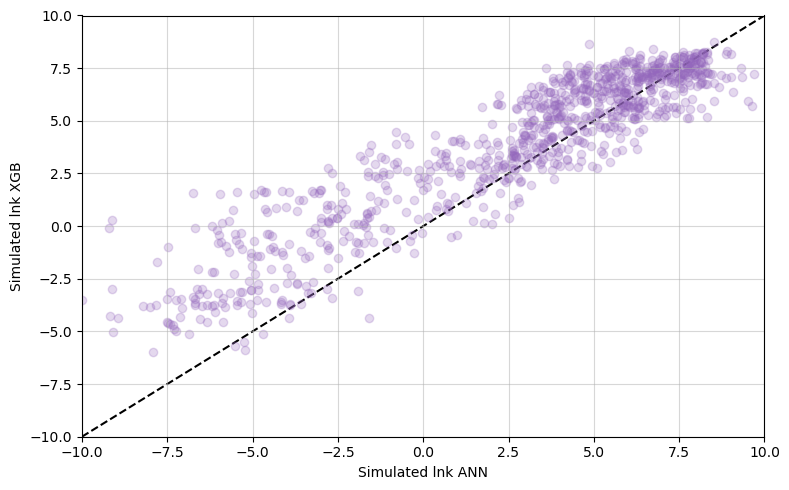

In [357]:
plt.figure(figsize=(8,5))
lims = 10
for i in range(n_simulations):
    plt.scatter(simulated_lnk_ann[i], simulated_lnk_xgb[i], marker='o', alpha=0.25, color='C4')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-lims, lims); plt.ylim(-lims, lims)
plt.xlabel('Simulated lnk ANN'); plt.ylabel('Simulated lnk XGB')
plt.tight_layout()
plt.show()

***
### RF Predictions

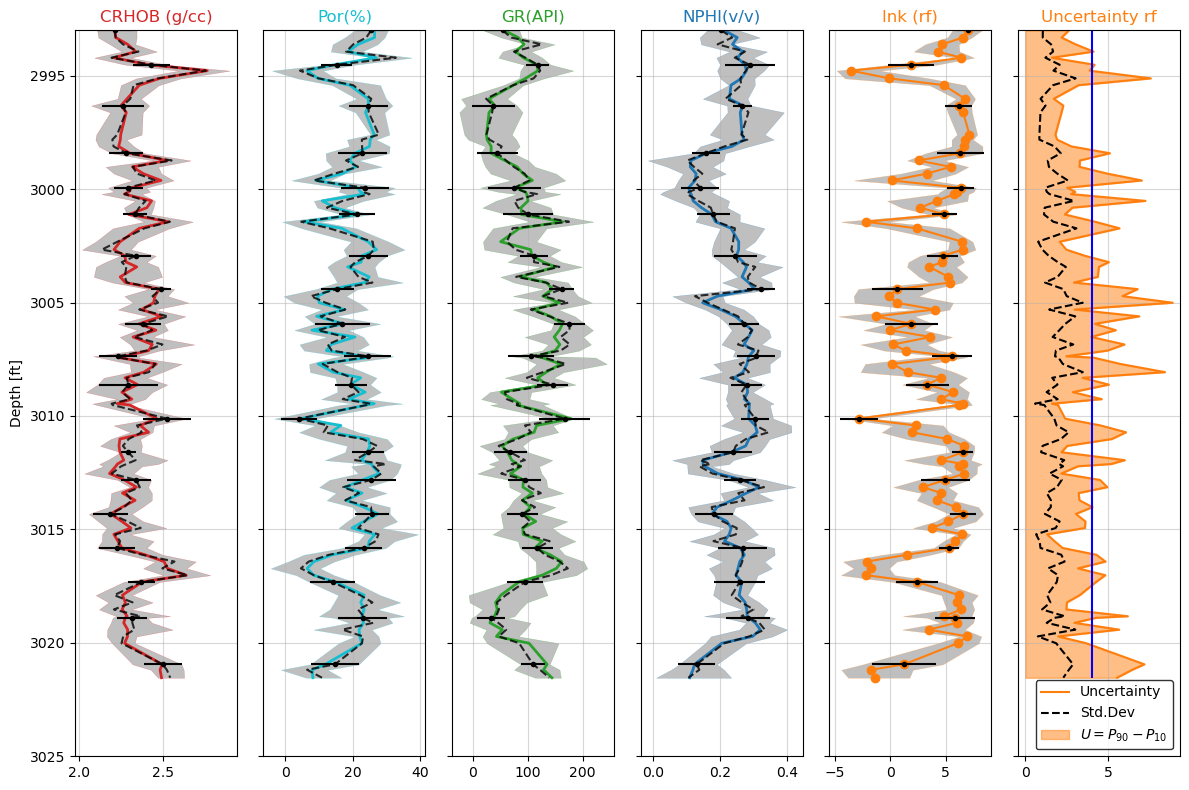

In [369]:
# uncertainty = P90 - P10
simulated_perct_rf = np.percentile(simulated_lnk_rf, [10, 90], axis=0)
simulated_unc_rf   = simulated_perct_rf[1] - simulated_perct_rf[0]
simulated_std_rf   = np.std(simulated_lnk_rf, axis=0)

hues = ['tab:red', 'tab:cyan', 'tab:green', 'tab:blue', 'tab:orange']
err_lag = 5
lb, ub = 10, 90
unc_cutoff = 4

fig, axs = plt.subplots(1, 6, figsize=(12, 8), sharey=True)
for j in range(4):
    ax = axs[j]
    ax.fill_betweenx(depth, np.percentile(random_inputs[...,j], lb, axis=0), np.percentile(random_inputs[...,j], ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[j], lw=0.25)
    ax.plot(X_test.iloc[:,j], depth, color=hues[j], lw=2)                       # True
    ax.plot(random_inputs[:,:,j].mean(0), depth, color='k', ls='--', alpha=0.8) # Ensemble pred
    ax.errorbar(random_inputs[:,::err_lag,j].mean(0), depth[::err_lag], xerr=random_inputs[:,::err_lag,j].std(0), fmt='.', color='k')
    ax.set_title(X_test.columns[j], color=hues[j])

axs[-2].plot(simulated_lnk_rf.mean(0), depth, color=hues[-1], marker='o')
axs[-2].fill_betweenx(depth, np.percentile(simulated_lnk_rf, lb, axis=0), np.percentile(simulated_lnk_rf, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
axs[-2].errorbar(simulated_lnk_rf[:,::err_lag].mean(0), depth[::err_lag], xerr=simulated_lnk_rf[:,::err_lag].std(0), fmt='.', color='k')
axs[-2].set_title('lnk (rf)', color=hues[-1])

axs[-1].plot(simulated_unc_rf, depth, color=hues[-1], label='Uncertainty')
axs[-1].plot(simulated_std_rf, depth, color='k', ls='--', label='Std.Dev')
axs[-1].vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
axs[-1].fill_betweenx(depth, 0, simulated_unc_rf, color=hues[-1], alpha=0.5, label='$U=P_{90}-P_{10}$')
axs[-1].legend(loc='lower right', edgecolor='k')
axs[-1].set_title('Uncertainty rf', color=hues[-1])

ax.invert_yaxis()
axs[0].set_ylabel('Depth [ft]')
axs[0].set_ylim(3025, 2993)
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()


***
### XGB Predictions

In [358]:
# uncertainty = P90 - P10
simulated_perct_xgb = np.percentile(simulated_lnk_xgb, [10, 90], axis=0)
simulated_unc_xgb   = simulated_perct_xgb[1] - simulated_perct_xgb[0]
simulated_std_xgb   = np.std(simulated_lnk_xgb, axis=0)

In [371]:
hues = ['tab:red', 'tab:cyan', 'tab:green', 'tab:blue', 'tab:orange']
err_lag = 5
lb, ub = 10, 90
unc_cutoff = 5

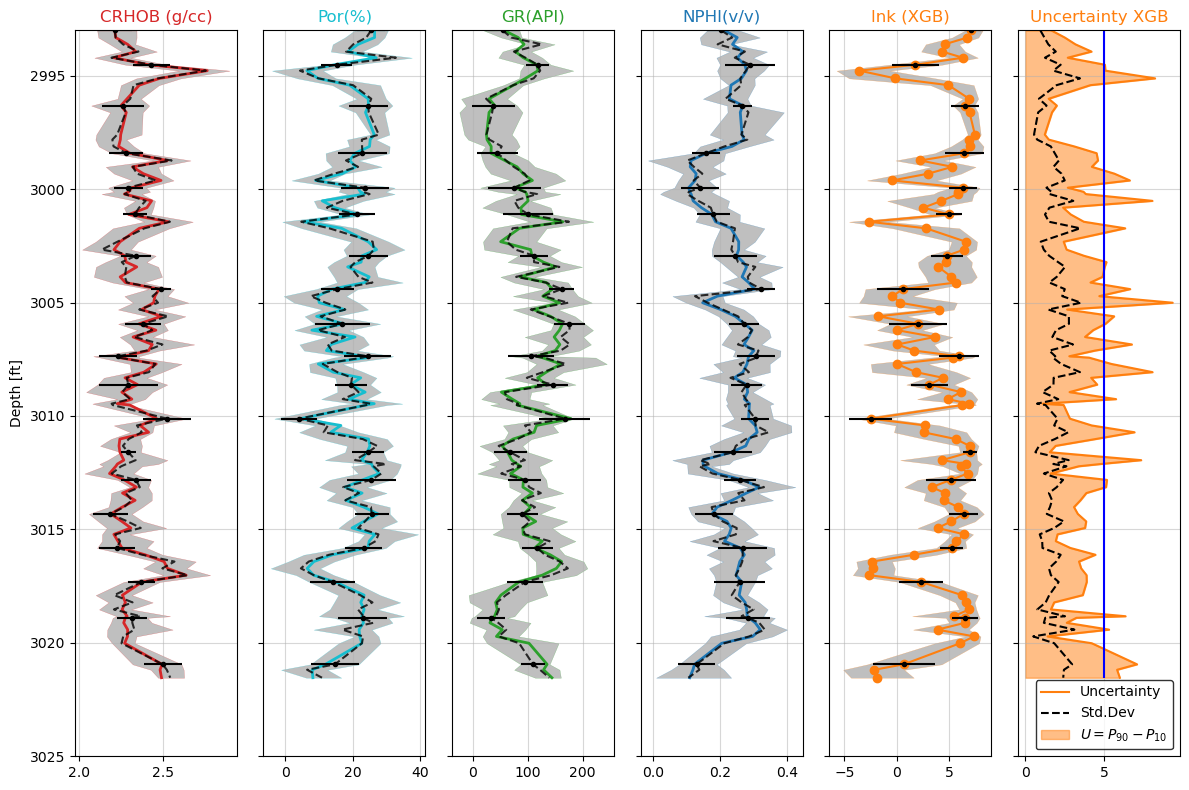

In [372]:
fig, axs = plt.subplots(1, 6, figsize=(12, 8), sharey=True)
for j in range(4):
    ax = axs[j]
    ax.fill_betweenx(depth, np.percentile(random_inputs[...,j], lb, axis=0), np.percentile(random_inputs[...,j], ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[j], lw=0.25)
    ax.plot(X_test.iloc[:,j], depth, color=hues[j], lw=2)                       # True
    ax.plot(random_inputs[:,:,j].mean(0), depth, color='k', ls='--', alpha=0.8) # Ensemble pred
    ax.errorbar(random_inputs[:,::err_lag,j].mean(0), depth[::err_lag], xerr=random_inputs[:,::err_lag,j].std(0), fmt='.', color='k')
    ax.set_title(X_test.columns[j], color=hues[j])

axs[-2].plot(simulated_lnk_xgb.mean(0), depth, color=hues[-1], marker='o')
axs[-2].fill_betweenx(depth, np.percentile(simulated_lnk_xgb, lb, axis=0), np.percentile(simulated_lnk_xgb, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
axs[-2].errorbar(simulated_lnk_xgb[:,::err_lag].mean(0), depth[::err_lag], xerr=simulated_lnk_xgb[:,::err_lag].std(0), fmt='.', color='k')
axs[-2].set_title('lnk (XGB)', color=hues[-1])

axs[-1].plot(simulated_unc_xgb, depth, color=hues[-1], label='Uncertainty')
axs[-1].plot(simulated_std_xgb, depth, color='k', ls='--', label='Std.Dev')
axs[-1].vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
axs[-1].fill_betweenx(depth, 0, simulated_unc_xgb, color=hues[-1], alpha=0.5, label='$U=P_{90}-P_{10}$')
axs[-1].legend(loc='lower right', edgecolor='k')
axs[-1].set_title('Uncertainty XGB', color=hues[-1])

ax.invert_yaxis()
axs[0].set_ylabel('Depth [ft]')
axs[0].set_ylim(3025, 2993)
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

In [366]:
fig, axs = plt.subplots(1, 10, figsize=(12,8), sharey=True)
for j in range(10):
    ax = axs[j]
    ax.plot(simulated_lnk_xgb.mean(0), depth, color='k', ls='--', lw=1) # Ensemble mean
    ax.plot(simulated_lnk_xgb[j], depth, color=hues[-1])                # Individual simulation/realization
    ax.fill_betweenx(depth, np.percentile(simulated_lnk_xgb, lb, axis=0), np.percentile(simulated_lnk_xgb, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
    ax.set_title('R{}'.format(j), color=hues[-1])
ax.invert_yaxis()
[a.grid(True, which='both', alpha=0.5) for a in axs]
[a.set(xlabel='lnk') for a in axs]
axs[0].set_ylabel('Depth [ft]')
plt.tight_layout()
plt.show()

***
### ANN Predictions

In [373]:
# uncertainty = P90 - P10
simulated_perct_ann = np.percentile(simulated_lnk_ann, [10, 90], axis=0)
simulated_unc_ann   = simulated_perct_ann[1] - simulated_perct_ann[0]
simulated_std_ann   = np.std(simulated_lnk_ann, axis=0)

In [374]:
hues = ['tab:red', 'tab:cyan', 'tab:green', 'tab:blue', 'tab:brown']
err_lag = 5
lb, ub = 10, 90

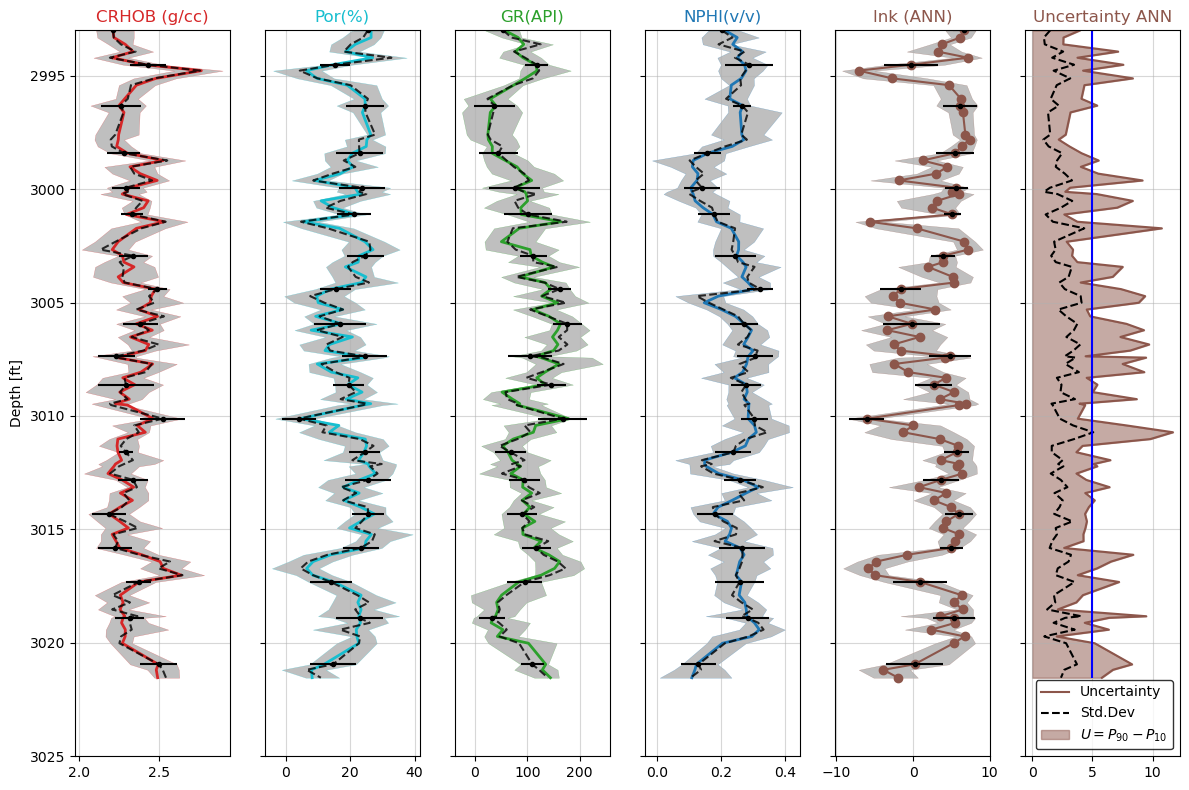

In [376]:
fig, axs = plt.subplots(1, 6, figsize=(12, 8), sharey=True)
for j in range(4):
    ax = axs[j]
    ax.fill_betweenx(depth, np.percentile(random_inputs[...,j], lb, axis=0), np.percentile(random_inputs[...,j], ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[j], lw=0.25)
    ax.plot(X_test.iloc[:,j], depth, color=hues[j], lw=2)                       # True
    ax.plot(random_inputs[:,:,j].mean(0), depth, color='k', ls='--', alpha=0.8) # Ensemble pred
    ax.errorbar(random_inputs[:,::err_lag,j].mean(0), depth[::err_lag], xerr=random_inputs[:,::err_lag,j].std(0), fmt='.', color='k')
    ax.set_title(X_test.columns[j], color=hues[j])

axs[-2].plot(simulated_lnk_ann.mean(0), depth, color=hues[-1], marker='o')
axs[-2].fill_betweenx(depth, np.percentile(simulated_lnk_ann, lb, axis=0), np.percentile(simulated_lnk_ann, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
axs[-2].errorbar(simulated_lnk_ann[:,::err_lag].mean(0), depth[::err_lag], xerr=simulated_lnk_ann[:,::err_lag].std(0), fmt='.', color='k')
axs[-2].set_title('lnk (ANN)', color=hues[-1])

axs[-1].plot(simulated_unc_ann, depth, color=hues[-1], label='Uncertainty')
axs[-1].plot(simulated_std_ann, depth, color='k', ls='--', label='Std.Dev')
axs[-1].vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
axs[-1].fill_betweenx(depth, 0, simulated_unc_ann, color=hues[-1], alpha=0.5, label='$U=P_{90}-P_{10}$')
axs[-1].legend(loc='lower right', edgecolor='k')
axs[-1].set_title('Uncertainty ANN', color=hues[-1])

ax.invert_yaxis()
axs[0].set_ylabel('Depth [ft]')
axs[0].set_ylim(3025, 2993)
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

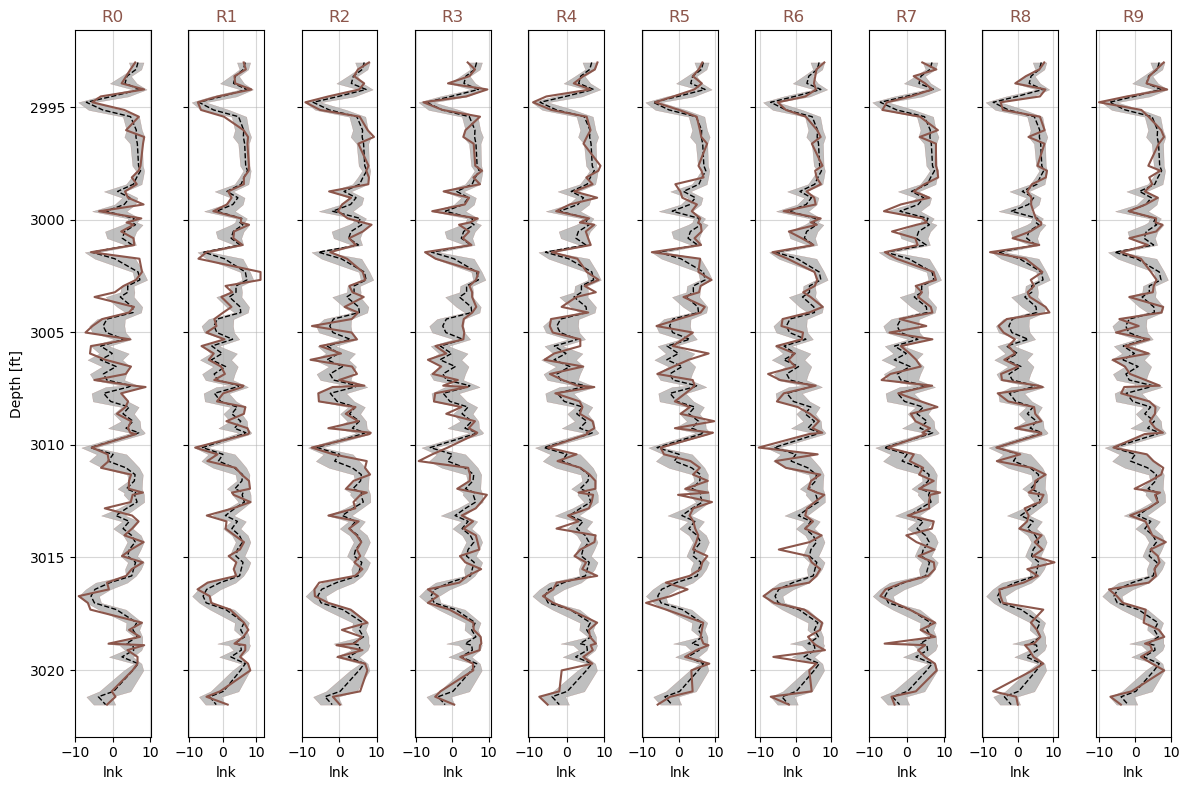

In [377]:
fig, axs = plt.subplots(1, 10, figsize=(12,8), sharey=True)
for j in range(10):
    ax = axs[j]
    ax.plot(simulated_lnk_ann.mean(0), depth, color='k', ls='--', lw=1) # Ensemble mean
    ax.plot(simulated_lnk_ann[j], depth, color=hues[-1])                # Individual simulation/realization
    ax.fill_betweenx(depth, np.percentile(simulated_lnk_ann, lb, axis=0), np.percentile(simulated_lnk_ann, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
    ax.set_title('R{}'.format(j), color=hues[-1])
ax.invert_yaxis()
[a.grid(True, which='both', alpha=0.5) for a in axs]
[a.set(xlabel='lnk') for a in axs]
axs[0].set_ylabel('Depth [ft]')
plt.tight_layout()
plt.show()

***
### LSTM Predictions

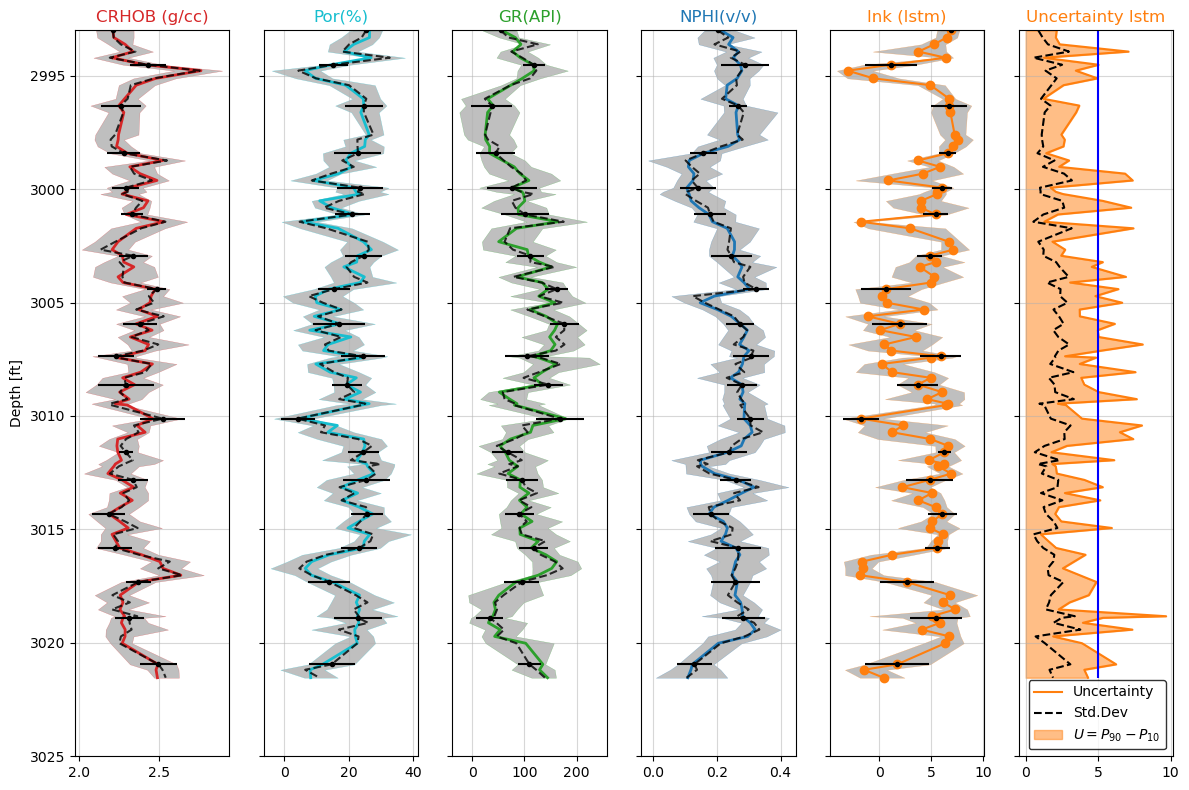

In [378]:
# uncertainty = P90 - P10
simulated_perct_lstm = np.percentile(simulated_lnk_lstm, [10, 90], axis=0)
simulated_unc_lstm   = simulated_perct_lstm[1] - simulated_perct_lstm[0]
simulated_std_lstm   = np.std(simulated_lnk_lstm, axis=0)


hues = ['tab:red', 'tab:cyan', 'tab:green', 'tab:blue', 'tab:orange']
err_lag = 5
lb, ub = 10, 90
unc_cutoff = 5


fig, axs = plt.subplots(1, 6, figsize=(12, 8), sharey=True)
for j in range(4):
    ax = axs[j]
    ax.fill_betweenx(depth, np.percentile(random_inputs[...,j], lb, axis=0), np.percentile(random_inputs[...,j], ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[j], lw=0.25)
    ax.plot(X_test.iloc[:,j], depth, color=hues[j], lw=2)                       # True
    ax.plot(random_inputs[:,:,j].mean(0), depth, color='k', ls='--', alpha=0.8) # Ensemble pred
    ax.errorbar(random_inputs[:,::err_lag,j].mean(0), depth[::err_lag], xerr=random_inputs[:,::err_lag,j].std(0), fmt='.', color='k')
    ax.set_title(X_test.columns[j], color=hues[j])

axs[-2].plot(simulated_lnk_lstm.mean(0), depth, color=hues[-1], marker='o')
axs[-2].fill_betweenx(depth, np.percentile(simulated_lnk_lstm, lb, axis=0), np.percentile(simulated_lnk_lstm, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
axs[-2].errorbar(simulated_lnk_lstm[:,::err_lag].mean(0), depth[::err_lag], xerr=simulated_lnk_lstm[:,::err_lag].std(0), fmt='.', color='k')
axs[-2].set_title('lnk (lstm)', color=hues[-1])

axs[-1].plot(simulated_unc_lstm, depth, color=hues[-1], label='Uncertainty')
axs[-1].plot(simulated_std_lstm, depth, color='k', ls='--', label='Std.Dev')
axs[-1].vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
axs[-1].fill_betweenx(depth, 0, simulated_unc_lstm, color=hues[-1], alpha=0.5, label='$U=P_{90}-P_{10}$')
axs[-1].legend(loc='lower right', edgecolor='k')
axs[-1].set_title('Uncertainty lstm', color=hues[-1])

ax.invert_yaxis()
axs[0].set_ylabel('Depth [ft]')
axs[0].set_ylim(3025, 2993)
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

***
### CNN Predictions

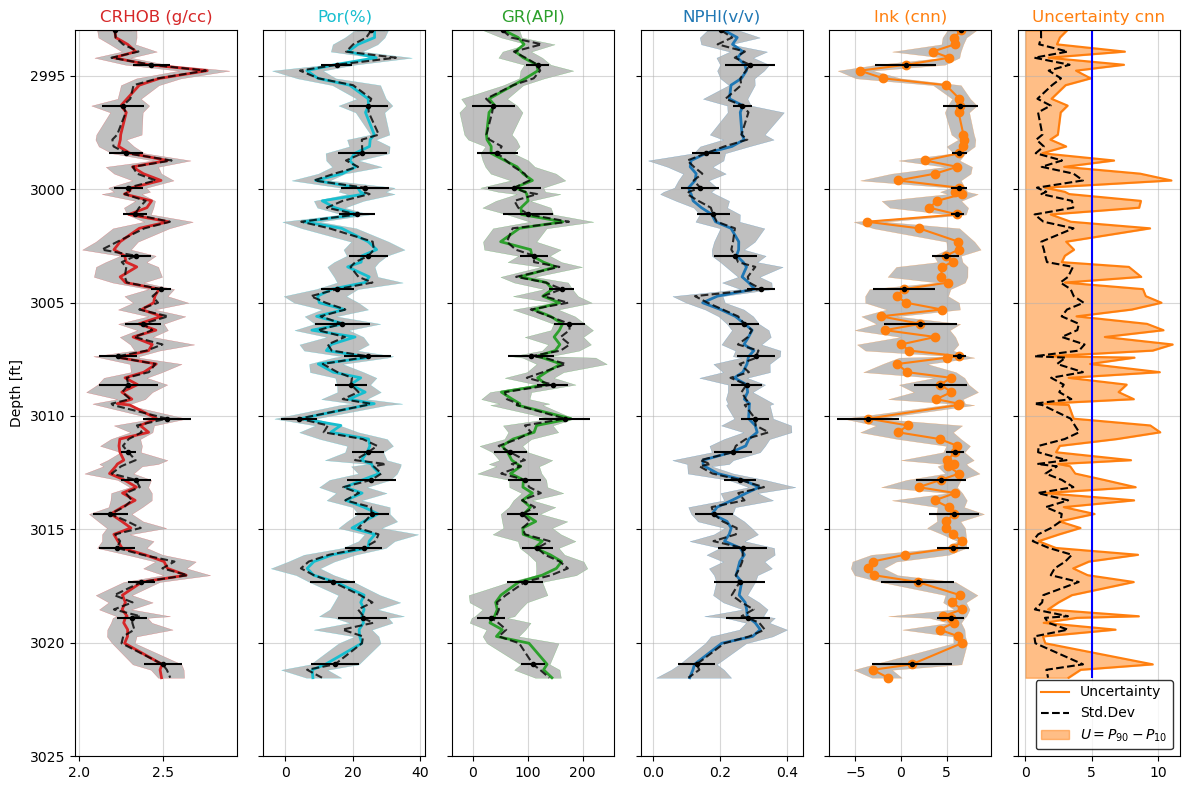

In [379]:
# uncertainty = P90 - P10
simulated_perct_cnn = np.percentile(simulated_lnk_cnn, [10, 90], axis=0)
simulated_unc_cnn   = simulated_perct_cnn[1] - simulated_perct_cnn[0]
simulated_std_cnn   = np.std(simulated_lnk_cnn, axis=0)


hues = ['tab:red', 'tab:cyan', 'tab:green', 'tab:blue', 'tab:orange']
err_lag = 5
lb, ub = 10, 90
unc_cutoff = 5


fig, axs = plt.subplots(1, 6, figsize=(12, 8), sharey=True)
for j in range(4):
    ax = axs[j]
    ax.fill_betweenx(depth, np.percentile(random_inputs[...,j], lb, axis=0), np.percentile(random_inputs[...,j], ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[j], lw=0.25)
    ax.plot(X_test.iloc[:,j], depth, color=hues[j], lw=2)                       # True
    ax.plot(random_inputs[:,:,j].mean(0), depth, color='k', ls='--', alpha=0.8) # Ensemble pred
    ax.errorbar(random_inputs[:,::err_lag,j].mean(0), depth[::err_lag], xerr=random_inputs[:,::err_lag,j].std(0), fmt='.', color='k')
    ax.set_title(X_test.columns[j], color=hues[j])

axs[-2].plot(simulated_lnk_cnn.mean(0), depth, color=hues[-1], marker='o')
axs[-2].fill_betweenx(depth, np.percentile(simulated_lnk_cnn, lb, axis=0), np.percentile(simulated_lnk_cnn, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
axs[-2].errorbar(simulated_lnk_cnn[:,::err_lag].mean(0), depth[::err_lag], xerr=simulated_lnk_cnn[:,::err_lag].std(0), fmt='.', color='k')
axs[-2].set_title('lnk (cnn)', color=hues[-1])

axs[-1].plot(simulated_unc_cnn, depth, color=hues[-1], label='Uncertainty')
axs[-1].plot(simulated_std_cnn, depth, color='k', ls='--', label='Std.Dev')
axs[-1].vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
axs[-1].fill_betweenx(depth, 0, simulated_unc_cnn, color=hues[-1], alpha=0.5, label='$U=P_{90}-P_{10}$')
axs[-1].legend(loc='lower right', edgecolor='k')
axs[-1].set_title('Uncertainty cnn', color=hues[-1])

ax.invert_yaxis()
axs[0].set_ylabel('Depth [ft]')
axs[0].set_ylim(3025, 2993)
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

***
### cVAE Predictions

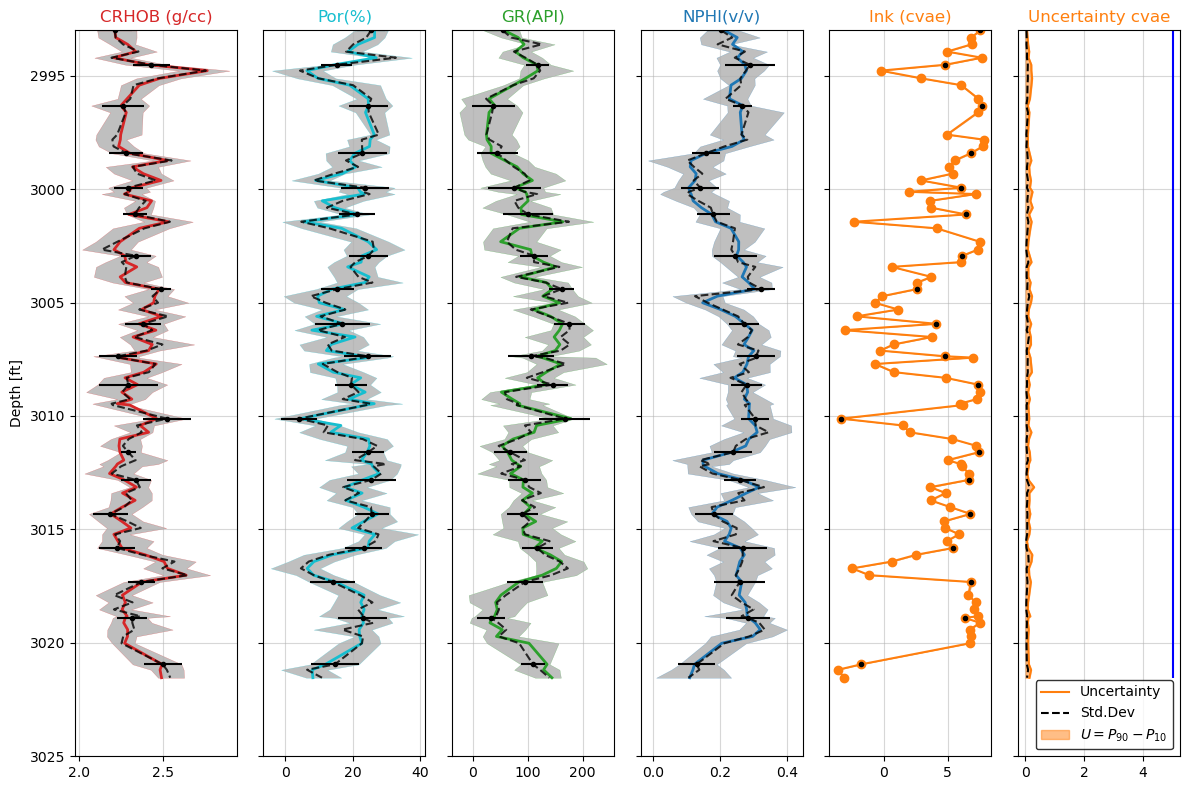

In [380]:
# uncertainty = P90 - P10
simulated_perct_cvae = np.percentile(simulated_lnk_cvae, [10, 90], axis=0)
simulated_unc_cvae   = simulated_perct_cvae[1] - simulated_perct_cvae[0]
simulated_std_cvae   = np.std(simulated_lnk_cvae, axis=0)


hues = ['tab:red', 'tab:cyan', 'tab:green', 'tab:blue', 'tab:orange']
err_lag = 5
lb, ub = 10, 90
unc_cutoff = 5


fig, axs = plt.subplots(1, 6, figsize=(12, 8), sharey=True)
for j in range(4):
    ax = axs[j]
    ax.fill_betweenx(depth, np.percentile(random_inputs[...,j], lb, axis=0), np.percentile(random_inputs[...,j], ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[j], lw=0.25)
    ax.plot(X_test.iloc[:,j], depth, color=hues[j], lw=2)                       # True
    ax.plot(random_inputs[:,:,j].mean(0), depth, color='k', ls='--', alpha=0.8) # Ensemble pred
    ax.errorbar(random_inputs[:,::err_lag,j].mean(0), depth[::err_lag], xerr=random_inputs[:,::err_lag,j].std(0), fmt='.', color='k')
    ax.set_title(X_test.columns[j], color=hues[j])

axs[-2].plot(simulated_lnk_cvae.mean(0), depth, color=hues[-1], marker='o')
axs[-2].fill_betweenx(depth, np.percentile(simulated_lnk_cvae, lb, axis=0), np.percentile(simulated_lnk_cvae, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
axs[-2].errorbar(simulated_lnk_cvae[:,::err_lag].mean(0), depth[::err_lag], xerr=simulated_lnk_cvae[:,::err_lag].std(0), fmt='.', color='k')
axs[-2].set_title('lnk (cvae)', color=hues[-1])

axs[-1].plot(simulated_unc_cvae, depth, color=hues[-1], label='Uncertainty')
axs[-1].plot(simulated_std_cvae, depth, color='k', ls='--', label='Std.Dev')
axs[-1].vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
axs[-1].fill_betweenx(depth, 0, simulated_unc_cvae, color=hues[-1], alpha=0.5, label='$U=P_{90}-P_{10}$')
axs[-1].legend(loc='lower right', edgecolor='k')
axs[-1].set_title('Uncertainty cvae', color=hues[-1])

ax.invert_yaxis()
axs[0].set_ylabel('Depth [ft]')
axs[0].set_ylim(3025, 2993)
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

***
### cGAN Predictions

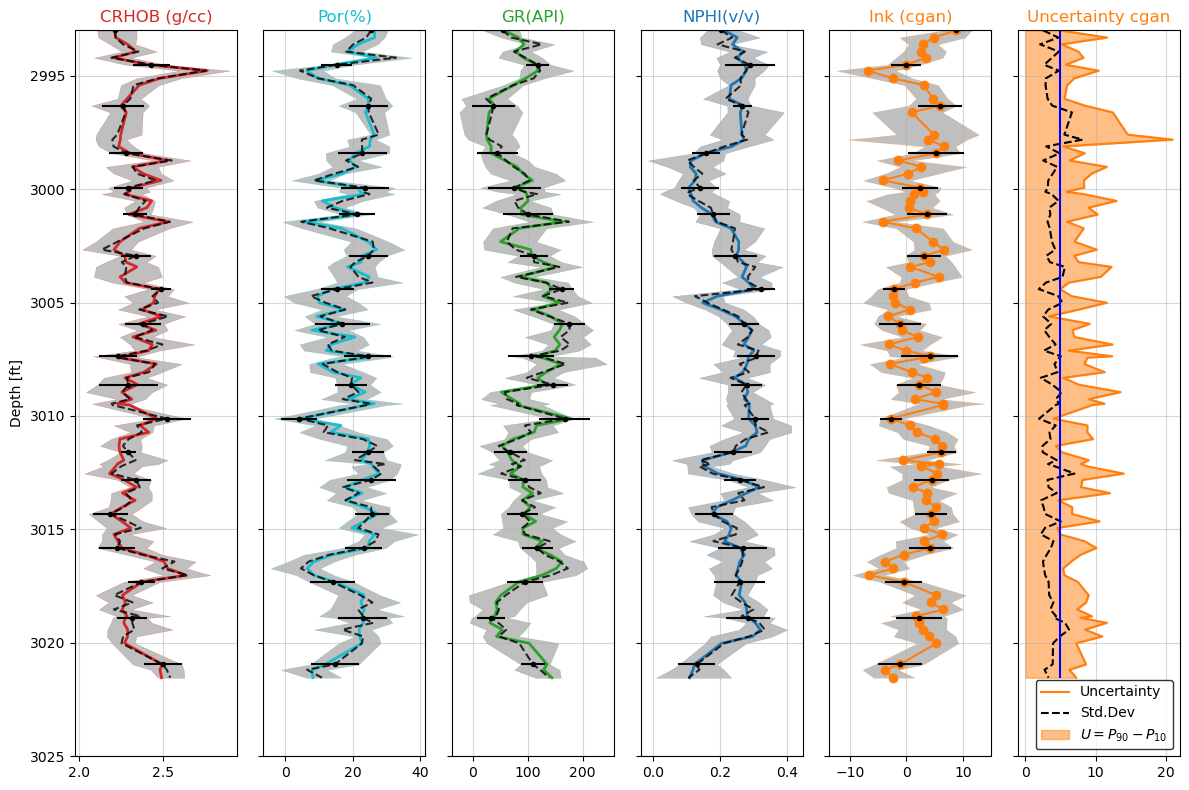

In [382]:
# uncertainty = P90 - P10
simulated_perct_cgan = np.percentile(simulated_lnk_cgan, [10, 90], axis=0)
simulated_unc_cgan   = simulated_perct_cgan[1] - simulated_perct_cgan[0]
simulated_std_cgan   = np.std(simulated_lnk_cgan, axis=0)


hues = ['tab:red', 'tab:cyan', 'tab:green', 'tab:blue', 'tab:orange']
err_lag = 5
lb, ub = 10, 90
unc_cutoff = 5


fig, axs = plt.subplots(1, 6, figsize=(12, 8), sharey=True)
for j in range(4):
    ax = axs[j]
    ax.fill_betweenx(depth, np.percentile(random_inputs[...,j], lb, axis=0), np.percentile(random_inputs[...,j], ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[j], lw=0.25)
    ax.plot(X_test.iloc[:,j], depth, color=hues[j], lw=2)                       # True
    ax.plot(random_inputs[:,:,j].mean(0), depth, color='k', ls='--', alpha=0.8) # Ensemble pred
    ax.errorbar(random_inputs[:,::err_lag,j].mean(0), depth[::err_lag], xerr=random_inputs[:,::err_lag,j].std(0), fmt='.', color='k')
    ax.set_title(X_test.columns[j], color=hues[j])

axs[-2].plot(simulated_lnk_cgan.mean(0), depth, color=hues[-1], marker='o')
axs[-2].fill_betweenx(depth, np.percentile(simulated_lnk_cgan, lb, axis=0), np.percentile(simulated_lnk_cgan, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
axs[-2].errorbar(simulated_lnk_cgan[:,::err_lag].mean(0), depth[::err_lag], xerr=simulated_lnk_cgan[:,::err_lag].std(0), fmt='.', color='k')
axs[-2].set_title('lnk (cgan)', color=hues[-1])

axs[-1].plot(simulated_unc_cgan, depth, color=hues[-1], label='Uncertainty')
axs[-1].plot(simulated_std_cgan, depth, color='k', ls='--', label='Std.Dev')
axs[-1].vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
axs[-1].fill_betweenx(depth, 0, simulated_unc_cgan, color=hues[-1], alpha=0.5, label='$U=P_{90}-P_{10}$')
axs[-1].legend(loc='lower right', edgecolor='k')
axs[-1].set_title('Uncertainty cgan', color=hues[-1])

ax.invert_yaxis()
axs[0].set_ylabel('Depth [ft]')
axs[0].set_ylim(3025, 2993)
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

***
### Compare UQ by regressor

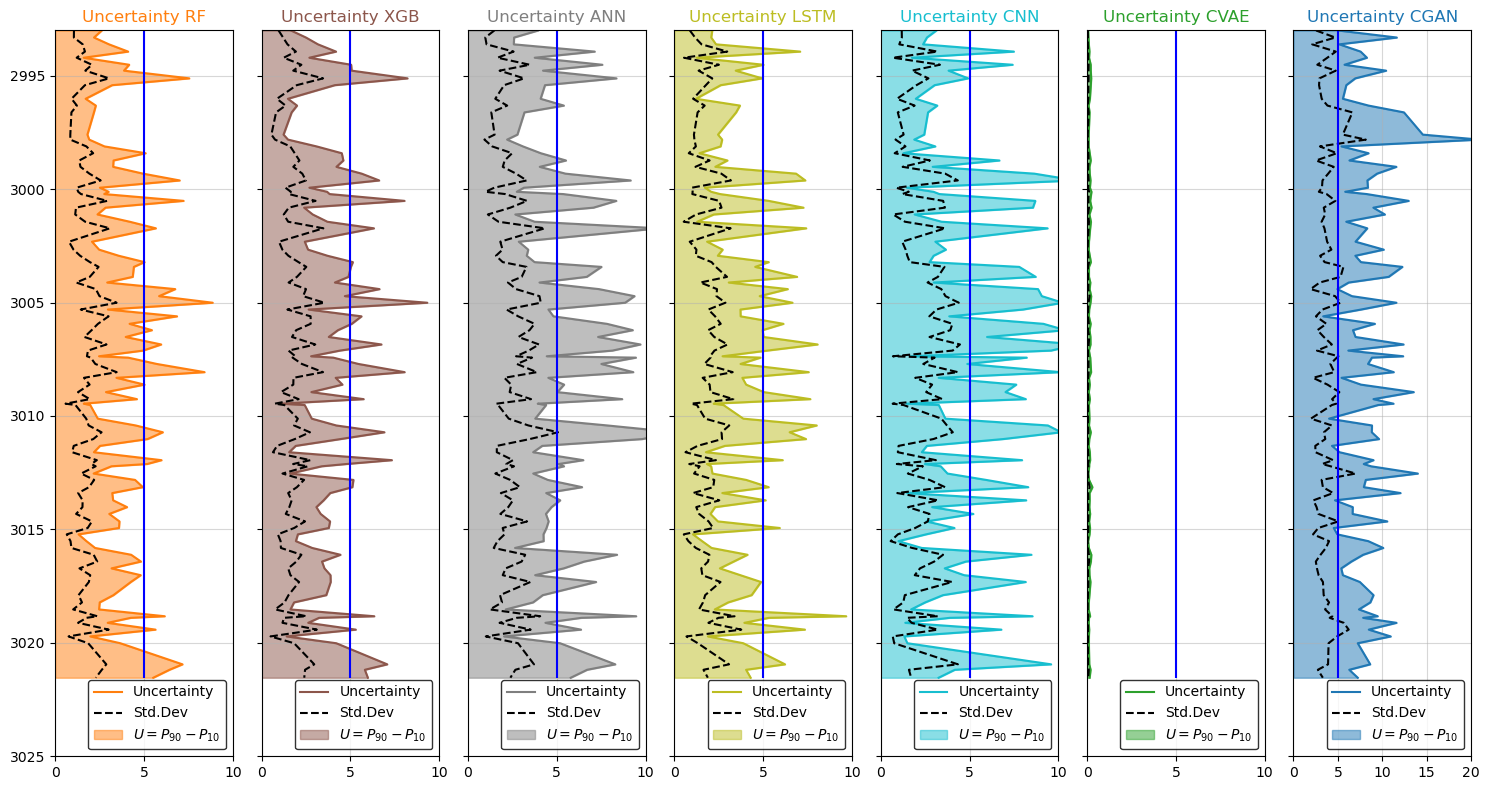

In [401]:
hues = ['tab:orange','tab:brown','tab:gray','tab:olive','tab:cyan','tab:green','tab:blue','tab:red','tab:pink','tab:purple']

fig, axs = plt.subplots(1, 7, figsize=(15,8), sharex=False, sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axs

ax1.plot(simulated_unc_rf, depth, color=hues[0], label='Uncertainty')
ax1.plot(simulated_std_rf, depth, color='k', ls='--', label='Std.Dev')
ax1.vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
ax1.fill_betweenx(depth, 0, simulated_unc_rf, color=hues[0], alpha=0.5, label='$U=P_{90}-P_{10}$')
ax1.legend(loc='lower right', edgecolor='k')
ax1.set_title('Uncertainty RF', color=hues[0])
ax1.set_xlim(0, 10)
ax1.set_xticks([0,5, 10])

ax2.plot(simulated_unc_xgb, depth, color=hues[1], label='Uncertainty')
ax2.plot(simulated_std_xgb, depth, color='k', ls='--', label='Std.Dev')
ax2.vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
ax2.fill_betweenx(depth, 0, simulated_unc_xgb, color=hues[1], alpha=0.5, label='$U=P_{90}-P_{10}$')
ax2.legend(loc='lower right', edgecolor='k')
ax2.set_title('Uncertainty XGB', color=hues[1])
ax2.set_xlim(0, 10)
ax2.set_xticks([0,5, 10])

ax3.plot(simulated_unc_ann, depth, color=hues[2], label='Uncertainty')
ax3.plot(simulated_std_ann, depth, color='k', ls='--', label='Std.Dev')
ax3.vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
ax3.fill_betweenx(depth, 0, simulated_unc_ann, color=hues[2], alpha=0.5, label='$U=P_{90}-P_{10}$')
ax3.legend(loc='lower right', edgecolor='k')
ax3.set_title('Uncertainty ANN', color=hues[2])
ax3.set_xlim(0, 10)
ax3.set_xticks([0,5, 10])

ax4.plot(simulated_unc_lstm, depth, color=hues[3], label='Uncertainty')
ax4.plot(simulated_std_lstm, depth, color='k', ls='--', label='Std.Dev')
ax4.vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
ax4.fill_betweenx(depth, 0, simulated_unc_lstm, color=hues[3], alpha=0.5, label='$U=P_{90}-P_{10}$')
ax4.legend(loc='lower right', edgecolor='k')
ax4.set_title('Uncertainty LSTM', color=hues[3])
ax4.set_xlim(0, 10)
ax4.set_xticks([0,5, 10])

ax5.plot(simulated_unc_cnn, depth, color=hues[4], label='Uncertainty')
ax5.plot(simulated_std_cnn, depth, color='k', ls='--', label='Std.Dev')
ax5.vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
ax5.fill_betweenx(depth, 0, simulated_unc_cnn, color=hues[4], alpha=0.5, label='$U=P_{90}-P_{10}$')
ax5.legend(loc='lower right', edgecolor='k')
ax5.set_title('Uncertainty CNN', color=hues[4])
ax5.set_xlim(0, 10)
ax5.set_xticks([0,5, 10])

ax6.plot(simulated_unc_cvae, depth, color=hues[5], label='Uncertainty')
ax6.plot(simulated_std_cvae, depth, color='k', ls='--', label='Std.Dev')
ax6.vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
ax6.fill_betweenx(depth, 0, simulated_unc_cvae, color=hues[5], alpha=0.5, label='$U=P_{90}-P_{10}$')
ax6.legend(loc='lower right', edgecolor='k')
ax6.set_title('Uncertainty CVAE', color=hues[5])
ax6.set_xlim(0, 10)
ax6.set_xticks([0,5, 10])

ax7.plot(simulated_unc_cgan, depth, color=hues[6], label='Uncertainty')
ax7.plot(simulated_std_cgan, depth, color='k', ls='--', label='Std.Dev')
ax7.vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
ax7.fill_betweenx(depth, 0, simulated_unc_cgan, color=hues[6], alpha=0.5, label='$U=P_{90}-P_{10}$')
ax7.legend(loc='lower right', edgecolor='k')
ax7.set_title('Uncertainty CGAN', color=hues[6])
ax7.set_xlim(0, 20)

ax1.invert_yaxis()
ax1.set_ylim(3025, 2993)
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

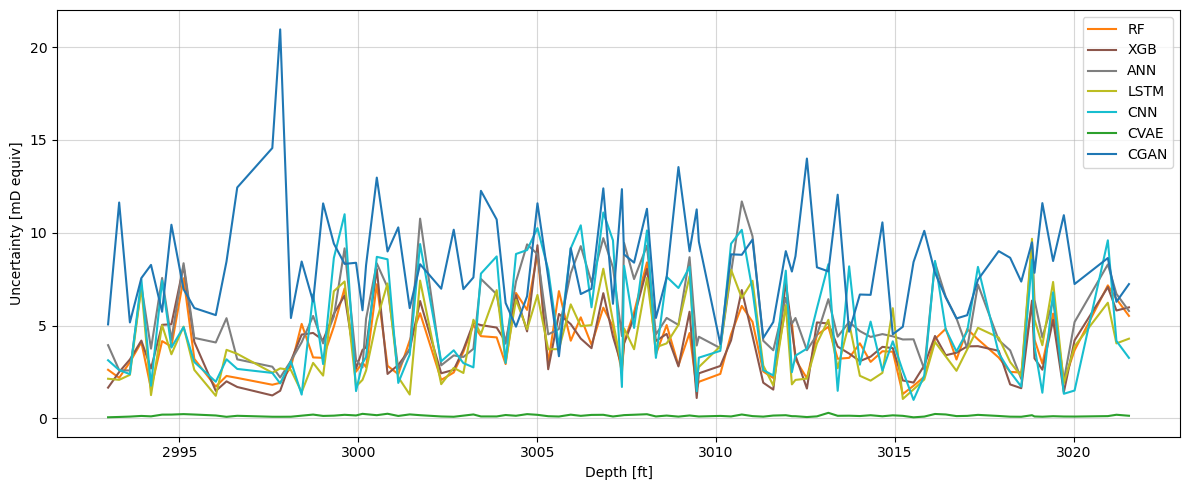

In [402]:
plt.figure(figsize=(12,5))
plt.plot(depth, simulated_unc_rf, color=hues[0], label='RF')
plt.plot(depth, simulated_unc_xgb, color=hues[1], label='XGB')
plt.plot(depth, simulated_unc_ann, color=hues[2], label='ANN')
plt.plot(depth, simulated_unc_lstm, color=hues[3], label='LSTM')
plt.plot(depth, simulated_unc_cnn, color=hues[4], label='CNN')
plt.plot(depth, simulated_unc_cvae, color=hues[5], label='CVAE')
plt.plot(depth, simulated_unc_cgan, color=hues[6], label='CGAN')

plt.xlabel('Depth [ft]'); plt.ylabel('Uncertainty [mD equiv]')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.tight_layout()
plt.show()

***
# END